# Lab 5: Bayesian Decoding

**STATS320: Machine Learning Methods for Neural Data Analysis**

_Stanford University. Winter, 2023._

---

**Team Name:** _Your team name here_

**Team Members:** _Names of everyone on your team here_

*Due: 11:59pm Thursday, Feb 23, 2023 via GradeScope*

---

The previous lab developed nonlinear _encoder_ models for predicting neural responses to sensory stimuli.  This week we'll develop _decoder_ models for inferring movements from neural spike trains.  One way to decode is via Bayesian inference: if we have a strong encoding model and a good prior distribution on movements, we can combine them to infer the posterior distribution of movements given spikes. This allows us to build constraints into the prior; e.g. that movements tend to be smooth. Ultimately, decoding is just another regression problem, and the Bayesian approach offers just one way of constructing a conditional distribution of movements given spikes. In this lab, we'll start with a Bayesian approach and then take a step back and construct a "direct" decoder that captures the dynamical structure of the Bayesian models while also capturing nonlinear features of the spike train.

We'll use a dataset from the [Prof. Krishna Shenoy](https://shenoy.people.stanford.edu/), a leader in the field of motor neuroscience who sadly passed away a few weeks ago. Please read this memorial of [his life and work](https://engineering.stanford.edu/magazine/krishna-shenoy-engineer-who-reimagined-how-brain-makes-body-move-dies-54). The data consists of a 96-channel Utah array recording from motor cortex of a non-human primate performing a center-out reaching task. The data and a related model are described in (Gilja\*, Nuyujukian\*, et al, 2012).


**References**

Gilja, Vikash, Paul Nuyujukian, Cindy A. Chestek, John P. Cunningham, Byron M. Yu, Joline M. Fan, Mark M. Churchland, et al. 2012. “A High-Performance Neural Prosthesis Enabled by Control Algorithm Design.” _Nature Neuroscience_ 15 (12): 1752–57.


## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.distributions import MultivariateNormal

from tqdm.auto import trange
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from dataclasses import dataclass

In [2]:
#@title Helper functions

# Set some plotting defaults
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "greyish",
                            "orange",
                            "amber",
                            "clay",
                            "pink"])

@dataclass
class Trial:
    spikes: torch.Tensor
    position: torch.Tensor
    velocity: torch.Tensor
    condition: torch.Tensor


class ReachDataset(Dataset):
    """A simple dataset object.
    """
    def __init__(self, spikes, position, velocity, condition, **kwargs):
        self.spikes = spikes
        self.position = position
        self.velocity = velocity
        self.condition = condition
        assert len(self.spikes) == len(self.position)
        assert len(self.spikes) == len(self.velocity)
        assert len(self.spikes) == len(self.condition)

    def __len__(self):
        return self.spikes.shape[0]

    def __getitem__(self, idx):
        # Binarize the stimulus, move it and the spikes to the GPU,
        # and package into a dictionary
        return Trial(spikes=self.spikes[idx],
                     position=self.position[idx],
                     velocity=self.velocity[idx],
                     condition=self.condition[idx])
        

def train_model(model, 
                train_dataset, 
                val_dataset,
                objective,
                regularizer=None,
                num_epochs=100, 
                lr=0.1,
                momentum=0.9,
                lr_step_size=25,
                lr_gamma=0.9):
    """Helper function to fit a model and return the weights with the best 
    loss on the validation dataset.
    """
    # progress bars
    pbar = trange(num_epochs)
    pbar.set_description("---")
    inner_pbar = trange(len(train_dataset))
    inner_pbar.set_description("Batch")

    # data loaders for train and validation
    # train_dataloader = DataLoader(train_dataset, batch_size=1)
    train_dataloader = train_dataset
    # val_dataloader = DataLoader(val_dataset, batch_size=1)
    val_dataloader = val_dataset
    dataloaders = dict(train=train_dataloader, val=val_dataloader)

    # use standard SGD with a decaying learning rate
    optimizer = optim.SGD(model.parameters(), 
                          lr=lr, 
                          momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    # Keep track of the best model
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                inner_pbar.reset()
            else:
                model.eval()
            
            # track the running loss over batches
            running_loss = 0
            running_size = 0
            for datapoint in dataloaders[phase]:
                velocity = datapoint.velocity.squeeze(0)
                spikes = datapoint.spikes.squeeze(0)
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()
                        # compute the model output and loss
                        output = model(spikes)
                        loss = objective(output, velocity)
                        # only add the regularizer in the training phase
                        if regularizer is not None:
                            loss += regularizer(model)

                        # take the gradient and perform an sgd step
                        loss.backward()
                        optimizer.step()
                    inner_pbar.update(1)
                else:
                    # just compute the loss in validation
                    output = model(spikes)
                    loss = objective(output, velocity)

                assert torch.isfinite(loss)
                running_loss += loss.item()
                running_size += 1
            
            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())

        # Update the learning rate
        scheduler.step()

        # Update the progress bar
        pbar.set_description("Epoch {:03} Train {:.4f} Val {:.4f}"\
                             .format(epoch, train_losses[-1], val_losses[-1]))
        pbar.update(1)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return torch.tensor(train_losses), torch.tensor(val_losses)

### Load the data

We have preprocessed the data into training, validation, and test dictionaries. We'll wrap them in `ReachDataset` objects below, but first we do a bit of preprocessing to account for delays between spikes and movement.

In [3]:
!wget -nc https://www.dropbox.com/s/gu58kxqfye6ewcl/lab5_data.pt
_train_data, _val_data, _test_data = torch.load('lab5_data.pt')

--2023-02-17 07:20:33--  https://www.dropbox.com/s/gu58kxqfye6ewcl/lab5_data.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/gu58kxqfye6ewcl/lab5_data.pt [following]
--2023-02-17 07:20:34--  https://www.dropbox.com/s/raw/gu58kxqfye6ewcl/lab5_data.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc903d20dec03a53a6e4541c054.dl.dropboxusercontent.com/cd/0/inline/B2oanB-2iLrO_9nLwHCoOLzXdXGOIm8YAsqoaldbZXdxr4H8q3NDA81IVJJFnIQ5nvrNhhGTYjUbO93v7fMaN0a5l-hXdYgt3ifFGTyGUxu4QDQJVkQQaq45UqJ-mu3UYjgm7eYAr97rsKCgDx6TZnAl5jcHZC4uclSdkaNJPtOS1w/file# [following]
--2023-02-17 07:20:34--  https://ucc903d20dec03a53a6e4541c054.dl.dropboxusercontent.com/cd/0/inline/B2oanB-2iLrO_9nLwHCoOLzXdXGOIm8YAsqoaldbZXdxr4H8q3NDA81IVJJFnIQ5nvrNhhGTYjUbO93v

### Compute the average spike triggered average

The average STA over the 96 channels shows that spikes tend to precede velocity changes by 100-125 ms ($\sim$ 5 bins).

Text(0, 0.5, 'spike triggered avg. velocity')

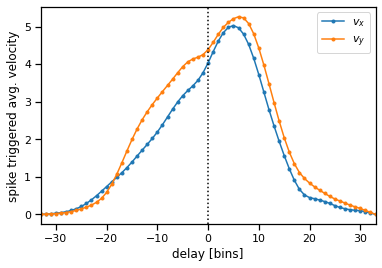

In [4]:
def compute_sta(data, channel, delay):
    spikes = data['spikes'] 
    velocity = data['velocity']
    
    num_trials, num_timesteps, num_chan = spikes.shape 

    pad_velocity = torch.cat([
        torch.zeros((num_trials, delay, 2)),
        velocity,
        torch.zeros((num_trials, delay, 2))],
        axis=1)
    
    X = torch.row_stack([
            torch.row_stack([
                torch.ravel(pad_velocity[i, t-delay:t+delay+1, :])
                for t in range(delay, delay+num_timesteps)])
            for i in range(num_trials)])
    
    Y = spikes.reshape((-1, num_chan))
    W = Y.T @ X 
    W /= Y.sum(axis=0).unsqueeze(1)
    W = W.reshape((-1, 2 * delay + 1, 2))
    return W

delay = 33
chan = 20
W = compute_sta(_train_data, chan, delay)
W_norm = torch.linalg.norm(W, axis=0)
plt.plot(torch.arange(-delay, delay+1), W_norm[:, 0], marker='.', label='$v_x$')
plt.plot(torch.arange(-delay, delay+1), W_norm[:, 1], marker='.', label='$v_y$')
plt.xlim(-delay, delay)
plt.axvline(0, ls=':', color='k')
plt.legend()
plt.xlabel("delay [bins]")
plt.ylabel("spike triggered avg. velocity")

### Account for delay

Pad the spikes with zeros to account for this delay.

In [5]:
def lag_spikes(spikes, lag):
    num_trials, num_timesteps, num_channels = spikes.shape
    pad = torch.zeros((num_trials, lag, num_channels))
    return torch.cat([pad, spikes], axis=1)[:, :num_timesteps, :]

for _data in [_train_data, _val_data, _test_data]:
    _data["orig_spikes"] = torch.clone(_data["spikes"])
    _data["spikes"] = lag_spikes(_data["spikes"], lag=5)


### Package the data into datasets

Now that we've added a lag to the spike counts, package the results into a dataset to allow easier access and iteration below. 

In [6]:
# Package data dictionaries into datasets
train_dataset = ReachDataset(**_train_data)
val_dataset = ReachDataset(**_val_data)
test_dataset = ReachDataset(**_test_data)

# Delete the old dictionaries so that we don't accidentally refernece them
del _train_data
del _val_data
del _test_data

Each dataset object contains the following fields:
- `spikes` a ($L \times T \times 96$) array of spike counts for each of the 96 channels where $L$ is the number of trials and $T$ is the number of 25ms time bins per trial
- `position` a ($L \times T \times 2$) array of cursor positions
- `velocity` a ($L \times T \times 2$) array of estimated cursor velocities
- `condition` a length $L$ tensor containing integers $0,\ldots,8$ specifying the reaching condition (i.e. starting point and target)

The dataset is also iterable. For example,

```
trial = train_dataset[0]    # Returns a Trial dataclass for trial 0
trial.spikes                # (T, 96) tensor of spikes
trial.position              # (T, 2) tensor of positions
trial.velocity              # (T, 2) tensor of velocities
trial.condition             # (int) condition id
```

### Plot the spike counts and position/velocity times for a single trial

Let's look at one trial. It consists of a time series of spike counts from each channel of the Utah array, as well as a position time series. We also plot the velocity, which is just a first-order estimate of the derivative of the position.

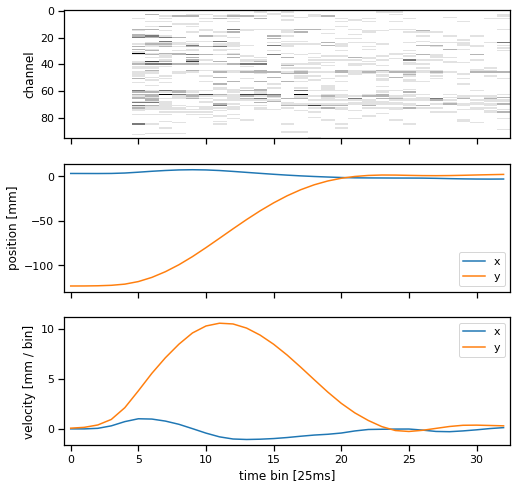

In [7]:
def plot_trial(trial, bin_size=25):
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
    axs[0].imshow(trial.spikes.T, 
                interpolation="none", 
                aspect="auto", 
                cmap="Greys")
    axs[0].set_ylabel("channel")
    
    axs[1].plot(trial.position[:, 0], label='x')
    axs[1].plot(trial.position[:, 1], label='y')
    axs[1].set_ylabel("position [mm]")
    axs[1].legend()

    axs[2].plot(trial.velocity[:, 0], label='x')
    axs[2].plot(trial.velocity[:, 1], label='y')
    axs[2].set_xlabel("time bin [{}ms]".format(bin_size))
    axs[2].set_ylabel("velocity [mm / bin]")
    axs[2].legend()

plot_trial(train_dataset[2])

### Plot the cursor positions across all trials

Plot the reach directions color-coded by the condition type. Most conditions start at the center and move outward to a target. One condition type (gray) starts at the perimeter and moves to the center.

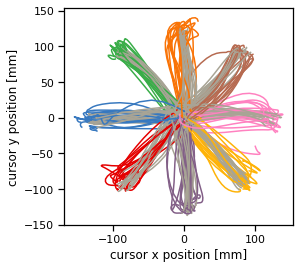

In [8]:
def plot_reach_trajectories(dataset):
    for trial in dataset:
        plt.plot(trial.position[:, 0], 
                 trial.position[:, 1], 
                 color=palette[trial.condition])
        
    plt.xlabel("cursor x position [mm]")
    plt.ylabel("cursor y position [mm]")
    plt.gca().set_aspect("equal")

plot_reach_trajectories(train_dataset)

## Part 1: Implement a simple Bayesian decoder

Our first model is an extremely simple Bayesian decoder.  Let $\mathbf{x}_{i,t} \in \mathbb{R}^2$ denote the **cursor velocity** at time $t$ on trial $i$. Likewise, let $\mathbf{y}_{i,t} \in \mathbb{R}^{96}$ denote the spike count measured on the 96-channel array at time $t$ on trial $i$. 

We will estimate the posterior distribution over velocity under the following model,

$$
\begin{aligned}
\mathbf{x}_{i,t} &\sim \mathcal{N}(\boldsymbol{0}, \mathbf{Q}) \\
\mathbf{y}_{i,t} \mid \mathbf{x}_{i,t} &\sim \mathcal{N}(\mathbf{C} \mathbf{x}_{i,t} + \mathbf{d}, \mathbf{R}).
\end{aligned}
$$

The model has the following parameters,
- $\mathbf{Q} \in \mathbb{R}^{2 \times 2}$: the prior covariance of the velocity
- $\mathbf{C} \in \mathbb{R}^{96 \times 2}$: the _emission_ matrix
- $\mathbf{d} \in \mathbb{R}^{96}$: the _emission_ bias
- $\mathbf{R} \in \mathbb{R}^{96 \times 96}$: the _emission_ covariance
Note that $\mathbf{Q}$ and $\mathbf{R}$ are positive definite matrices.

As we derived in class, the posterior distribution of the velocity given the spike counts is,

$$
\begin{aligned}
p(\mathbf{x}_{i,t} \mid \mathbf{y}_{i,t}) &= \mathcal{N}(\boldsymbol{\mu}_t, \boldsymbol{\Sigma}) \\
\boldsymbol{\Sigma} &= \mathbf{J}^{-1}  
& \boldsymbol{\mu}_t &= \mathbf{J}^{-1} \mathbf{h}_t \\
\mathbf{J} &= \mathbf{Q}^{-1} + \mathbf{C}^\top \mathbf{R}^{-1} \mathbf{C} &
\mathbf{h}_t &= \mathbf{C}^\top \mathbf{R}^{-1}(\mathbf{y}_{i,t} - \mathbf{d}),
\end{aligned}
$$

where $(\boldsymbol{\mu}_t, \boldsymbol{\Sigma})$ are the posterior mean and covariance, respectively, and $(\mathbf{J}, \mathbf{h}_t)$ are the _natural_ (aka _information-form_) parameters. 

To be consistent with the subsequent parts of the lab, we will formulate the model as a conditional distribution over the entire time series of velocities, $\mathbf{x}_i = (\mathbf{x}_{i,1}, \ldots, \mathbf{x}_{i,T}) \in \mathbb{R}^{T \times 2}$ given the entire time series of spike counts $\mathbf{y}_i \in \mathbb{R}^{T \times 96}$. Since the simple model factors into a product of Gaussians for each time bin, and since each Gaussian has the same covariance, the full posterior distribution is,

$$
\begin{aligned}
p(\mathbf{x}_i \mid \mathbf{y}_i) 
&= \prod_{t=1}^{T} p(\mathbf{x}_{i,t} \mid \mathbf{y}_{i,t}) \\
&= \mathcal{N}\left( \mathrm{vec}(\mathbf{x}_i) \, \bigg| \,
    \begin{bmatrix} \boldsymbol{\mu}_1 \\ \vdots \\ \boldsymbol{\mu}_{T} \end{bmatrix},
    \begin{bmatrix} \boldsymbol{\Sigma} & & \\ & \ddots & \\ & & \boldsymbol{\Sigma} \end{bmatrix} 
    \right).
\end{aligned}
$$

In Part 1, you'll estimate the parameters of this model, $\{\mathbf{Q}, \mathbf{C}, \mathbf{d}, \mathbf{R}\}$ and implement it as a PyTorch module.

### Problem 1a: Estimate the prior covariance

Estimate the prior covariance,

$$
\begin{aligned}
\hat{\mathbf{Q}} &= \frac{1}{LT} \left(\sum_{i=1}^L \sum_{t=1}^{T} (\mathbf{x}_{i,t} - \bar{\mathbf{x}}) (\mathbf{x}_{i,t} - \bar{\mathbf{x}})^\top \right).
\end{aligned}
$$

where $\bar{\mathbf{x}} \in \mathbb{R}^2$ is the mean velocity.

In [9]:
def estimate_basic_prior_prms(dataset):
    """
    Compute the covariance of the velocity over all 
    trials and time steps.
    """
    x = dataset.velocity
    
    ###
    # YOUR CODE BELOW
    Q = ...
    ###

    return Q
    
Q_hat = estimate_basic_prior_prms(train_dataset)
assert torch.allclose(
    Q_hat, torch.tensor([[19.3895, -1.2992],
                         [-1.2992, 20.6520]]), atol=1e-4)

### Problem 1b: Estimate the encoding model parameters

Estimate $\mathbf{C} \in \mathbb{R}^{96 \times 2}$, $\mathbf{d} \in \mathbb{R}^{96}$, and $\mathbf{R} \in \mathbb{R}^{96 \times 96}$ by fitting a linear regression to the training velocity and spikes.

Let $\mathbf{X} \in \mathbb{R}^{LT \times 3}$ denote the matrix of concatenated velocities across all trials with an additional column of ones for the intercept. Let $\mathbf{Y} \in \mathbb{R}^{LT \times 96}$ denote a matrix of spike counts concatenated across all trials.

The ordinary least squares estimate of the regression weights is,

$$
\mathbf{W} = \mathbf{Y}^\top \mathbf{X} (\mathbf{X}^\top \mathbf{X})^{-1} 
$$

where $\mathbf{W} = [ \mathbf{C}, \mathbf{d}] \in \mathbb{R}^{96 \times 3}$ are the desired parameters.

Set the covariance matrix $\mathbf{R} = \mathrm{Cov}(\boldsymbol{\delta}_{i,t})$ where $\boldsymbol{\delta}_{i,t} = \mathbf{y}_{i,t} - \mathbf{C} \mathbf{x}_{i,t} - \mathbf{d}$.



In [10]:
def estimate_emission_prms(dataset):
    X = dataset.velocity.reshape(-1, 2)
    X = torch.column_stack([X, torch.ones(X.shape[0])])
    Y = dataset.spikes.reshape(-1, 96)
    
    ###
    # YOUR CODE HERE
    C = ...
    d = ...
    R = ...
    ###
    
    return C, d, R

C_hat, d_hat, R_hat = estimate_emission_prms(train_dataset)

### Problem 1c: Implement the simple decoder model

Implement the simple decoder as a PyTorch `Module`. We won't be fitting any parameters (you just estimated them above!), but implementing it this way will allow us to compare directly to the model developed in Part 3.

Specifically, complete the `forward` function to compute `J`, `h`, `mu`, and `Sigma`. The functions `torch.linalg.solve` and `torch.linalg.inv` will be useful. 

_Note: there are generally more numerically stable/efficient approaches than directly computing a matrix inverse&mdash;solve is almost always preferable!&mdash;but for this lab go ahead and call `torch.linalg.inv` to compute `Sigma`._

In [11]:
class SimpleDecoder(nn.Module):
    def __init__(self, Q, C, d, R):
        super(SimpleDecoder, self).__init__()
        
        # Store the parameters as tensors
        self.Q = Q
        self.C = C
        self.d = d
        self.R = R
        
    def forward(self, spikes):
        """
        spikes: T x 96 array of spikes for a single trial
        returns: (mu, Sigma) where 
            - mu is the (T x 2) posterior mean of the velocity
            - Sigma is the (2 x 2) posterior covariance (the same for all bins)
        """
        # Get the model parameters so we don't always have to reference self
        Q, C, d, R = self.Q, self.C, self.d, self.R
        Y = spikes
        T, _ = Y.shape

        ###
        # YOUR CODE BELOW
        #
        J = ...     # 2x2 tensor
        Sigma = ... # 2x2 tensor
        h = ...     # Tx2 tensor
        mu = ...    # Tx2 tensor
        #
        ###

        # Convert Sigma to a 2T x 2T block diagonal matrix for consistency
        # with the models in Parts 2 and 3
        assert Sigma.shape == (2, 2)
        Sigma = torch.block_diag(*(Sigma * torch.ones(T, 2, 2)))

        # Return the mean and covariance
        return mu, Sigma
        

# Instantiate the model
Q_hat = estimate_basic_prior_prms(train_dataset)
C_hat, d_hat, R_hat = estimate_emission_prms(train_dataset)
simple_decoder = SimpleDecoder(Q_hat, C_hat, d_hat, R_hat)

# Check the decoder on an example trial
mu, Sigma = simple_decoder(train_dataset[0].spikes)
assert torch.isclose(torch.linalg.norm(mu), torch.tensor(24.6460), atol=1e-4)
assert torch.isclose(torch.linalg.norm(Sigma), torch.tensor(106.5529), atol=1e-4)

### Problem 1d: Compute the multivariate normal log probability

Write a function to compute the (average negative) log probability under the a multivariate normal distribution,

$$
\begin{aligned}
p(\mathbf{x}_i \mid \mathbf{y}_i) 
&= \prod_{t=1}^{T} p(\mathbf{x}_{i,t} \mid \mathbf{y}_{i,t}) \\
&= \mathcal{N}\left( \mathrm{vec}(\mathbf{x}_i) \, \bigg| \,
    \boldsymbol{\mu}, \mathbf{\Sigma}
    \right).
\end{aligned}
$$

where $\mathrm{vec}(\mathbf{x}_i) \in \mathbb{R}^{2T}$ is the vectorized array of velocities, $\boldsymbol{\mu} \in \mathbb{R}^{2T}$ is the mean, and $\boldsymbol{\Sigma} \in \mathbb{R}^{2T \times 2T}$ is the covariance matrix.

The function will take in the velocity and mean as shape `(T,2)` tensors, so you'll have to do some flattening. We'll negate and normalize for you.

In [12]:
def mvn_loss(prms, velocity):
    """Compute the average negative log-likelihood under a 
    multivariate normal model.

    prms: tuple containing (mean, cov) where:
        mean: T x 2 tensor of predicted velocity mean
        cov:  2T x 2T tensor of predicted velocity covariance
    velocity: T x 2 array of measured velocity
    returns: average negative log likelihood (mean over all spikes)
    """
    mean, cov = prms
    velocity = velocity
    
    ###
    # YOUR CODE BELOW
    ll = ...
    ###
    
    return -ll / velocity.numel()
    
assert torch.isclose(
    mvn_loss(simple_decoder(train_dataset[0].spikes), train_dataset[0].velocity),
    torch.tensor(2.4162), atol=1e-4)

### Plot the decoded positions
That's it! No more fitting required. You already estimated the parametes in Problems 1a and 1b. Now we'll decode the velocities from the test set and integrate them to get positions that we can compare to the true cursor trajectories.

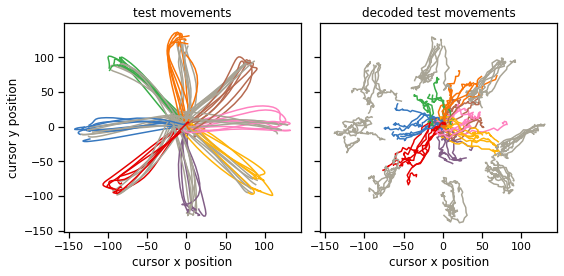

In [13]:
def plot_decoder(dataset, decoder):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    for trial in dataset:
        # decode velocity and integrate to get position
        dec_velocity = decoder(trial.spikes)[0]
        dec_position = trial.position[0] + torch.cumsum(dec_velocity, axis=0)

        color = palette[trial.condition]
        axs[0].plot(trial.position[:, 0], trial.position[:, 1], color=color)
        axs[1].plot(dec_position[:, 0], dec_position[:, 1], color=color)
    
    axs[0].set_title("test movements")
    axs[0].set_xlabel("cursor x position")
    axs[0].set_ylabel("cursor y position")
    axs[1].set_xlabel("cursor x position")
    axs[1].set_title("decoded test movements")
    plt.tight_layout()

plot_decoder(test_dataset, simple_decoder)

### Problem 1e: [Short answer] Explain your results

Why do the decoded trajectories look so noisy when the real trajectories are so smooth?

---



_Your answer here_


## Part 2: Bayesian decoding with a linear dynamical system prior

The simple model failed to account for any temporal correlations in the velocities. This followed from the fact that both the prior and the likelihood were independent across time bins. In this section, we'll address this shortcoming by building temporal dependencies into the prior.

Consider the following model instead,

$$
\begin{align}
\mathbf{x}_{i,1} &\sim \mathcal{N}(0, \mathbf{Q}_0) \\
\mathbf{x}_{i,t} &\sim \mathcal{N}(\mathbf{A} \mathbf{x}_{t-1}, \mathbf{Q}) & \text{for }  t&=2,\ldots, T\\
\mathbf{y}_{i,t} \mid \mathbf{x}_{i,t} &\sim \mathcal{N}(\mathbf{C} \mathbf{x}_{i,t} + \mathbf{d}, \mathbf{R}) 
 & \text{for }  t&=1,\ldots, T.
\end{align}
$$

Under this model, the velocity $\mathbf{x}_{i,t}$ is a linear function of the preceding velocity with additive Gaussian noise. This is called a _linear dynamical system_ (LDS). These autoregressive dependencies of the LDS lead to correlations across time in the posterior. 

### Problem 2a [Math]: Derive the natural parameters of the LDS posterior

Since the model is linear and Gaussian, the posterior distribution of the LDS is also a multivariate Gaussian,

$$
\begin{align}
p(\mathbf{x}_i \mid \mathbf{y}_i) 
&= \mathcal{N}\left( \mathrm{vec}(\mathbf{x}_i) \, \bigg| \,
    \boldsymbol{\mu}, \mathbf{\Sigma}
    \right).
\end{align}
$$

but here the covariance matrix $\boldsymbol{\Sigma} \in \mathbb{R}^{2T \times 2T}$ is no longer block diagonal. Instead, we have,

$$
\begin{aligned}
\boldsymbol{\Sigma} &= \mathbf{J}^{-1} &
\boldsymbol{\mu} &= \mathbf{J}^{-1} \mathbf{h} 
\end{aligned}
$$

where $\mathbf{J} \in \mathbb{R}^{2T \times 2T}$ is a block tridiagonal matrix and $\mathbf{h} \in \mathbb{R}^{2T}$ is a vector,

$$
\begin{aligned}
\mathbf{J} &=
\begin{bmatrix}
\mathbf{J}_{11} & \mathbf{J}_{21}^\top &    &           &                \\
\mathbf{J}_{21} & \mathbf{J}_{22} &  \ddots &           &                \\
       & \ddots & \ddots  & \ddots    &                \\
       &        & \ddots  & \ddots    & \mathbf{J}_{T,T-1}^\top \\
       &        &         & \mathbf{J}_{T,T-1} & \mathbf{J}_{T,T}
\end{bmatrix}
&
\mathbf{h} &=
\begin{bmatrix}
\mathbf{h}_1 \\
\mathbf{h}_2 \\
\vdots \\
\mathbf{h}_T
\end{bmatrix}
\end{aligned}
$$

Derive the information form (aka natural) parameters of the posterior distribution, including:
- the diagonal blocks $\mathbf{J}_{tt} \in \mathbb{R}^{2 \times 2}$ (including the special cases for $t=1$ and $t=T$), 
- the lower diagonal blocks $\mathbf{J}_{t,t-1} \in \mathbb{R}^{2 \times 2}$, and
- the linear terms $\mathbf{h}_t \in \mathbb{R}^2$. 

To do so, apply Bayes rule, expanding the joint probability, and collecting terms to write the posterior as a multivariate normal distribution on $\mathbf{x}_i$.

---

_Your answer here_

### Problem 2b: Estimate the velocity dynamics

Write a function to estimate the prior parameters $\hat{\mathbf{Q}}_0$, $\hat{\mathbf{A}}$, and $\hat{\mathbf{Q}}$. Estimate $\hat{\mathbf{Q}}_0$ as the empirical variance of the initial velocity (similar to Problem 1a), and estimate $\hat{\mathbf{A}}$ and $\hat{\mathbf{Q}}$ via linear regression (similar to Problem 1b).


In [14]:
def estimate_dynamics_prms(dataset):
    """
    Estimate the prior parameters Q0, A, and Q, as described above.
    """
    ###
    # YOUR CODE BELOW
    Q0 = ...
    A = ...
    Q = ...
    ###
    
    return Q0, A, Q

Q0_hat, A_hat, Q_hat = estimate_dynamics_prms(train_dataset)

### A helper function to construct a symmetric block tridiagonal matrix from its parts

In [15]:
def symm_block_tridiag(J_diag, J_lower_diag):
    """
    Helper function to construct a symmetric block tridiagonal matrix
    from its diagonal blocks (J_diag) and lower diagonal blocks (J_lower_diag).
    The shape of the output is inferred from the shapes of the inputs

    J_diag: T x D x D tensor of diagonal blocks
    J_lower_diag: T-1 x D x D tensor of lower diagonal blocks

    returns: TD x TD symmetric block tridiagonal matrix
    """
    T, D, _ = J_diag.shape
    assert J_diag.shape[2] == D
    assert J_lower_diag.shape == (T-1, D, D)

    J = torch.block_diag(*J_diag)
    J[D:, :-D] += torch.block_diag(*J_lower_diag)
    J[:-D, D:] += torch.block_diag(*torch.transpose(J_lower_diag, 1, 2))
    return J

### Problem 2c: Implement the LDS decoder

Implement the LDS decoder as a PyTorch module, using your derivations from Problem 2a and the helper function above to construct the big $\mathbf{J}$ matrix and $\mathbf{h}$ vector. Then use `torch.linalg.inv` to convert the natural parameters to mean parameters $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$. 

As in Part 1, return $\boldsymbol{\mu}$ as a `T x 2` tensor and $\boldsymbol{\Sigma}$ as a `2T x 2T` tensor.

**Note**: Inverting $\mathbf{J}$ naively takse $O(T^3)$ operations since it's a $2T \times 2T$ matrix.  We can get this down to $O(T)$ using the Kalman smoother&mdash;a dynamic programming algorithm. We'll talk more about this in class. For now, just pay the cubic price since these matrices aren't that big anyway.

In [16]:
class LDSDecoder(nn.Module):
    def __init__(self, Q0, A, Q, C, d, R):
        self.Q0 = Q0
        self.A = A
        self.Q = Q
        self.C = C
        self.d = d
        self.R = R
        super(LDSDecoder, self).__init__()
        
    def forward(self, spikes):
        """
        spikes: T x num_channels array of spikes for a single trial
        returns: (mu, Sigma) where 
            - mu is the (T x 2) posterior mean of the velocity
            - Sigma is the (2 x 2) posterior covariance (the same for all bins)
        """
        # Get the model parameters so we don't always have to reference self
        Q0, A, Q, C, d, R = self.Q0, self.A, self.Q, self.C, self.d, self.R
        Y = spikes
        T, _ = Y.shape

        ###
        # YOUR CODE BELOW

        # Initialize diagonal and lower diagonal blocks of J
        J_diag = torch.zeros(T, 2, 2)
        J_lower_diag = torch.zeros(T-1, 2, 2)

        # Fill in the blocks
        ...

        # Make the full J matrix
        J = symm_block_tridiag(J_diag, J_lower_diag)

        # Make h
        h = ...

        # Convert to standard parameters
        mu = ...
        Sigma = ...
        ###

        # Explicitly symmetrize and add a small bias to ensure PSD
        Sigma = 0.5 * (Sigma + Sigma.T) + 1e-4 * torch.eye(J.shape[0])
        assert torch.all(torch.isfinite(mu))
        assert torch.all(torch.isfinite(Sigma))
        return mu, Sigma
        
# Instantiate the decoder
Q0_hat, A_hat, Q_hat = estimate_dynamics_prms(train_dataset)
C_hat, d_hat, R_hat = estimate_emission_prms(train_dataset)
lds_decoder = LDSDecoder(Q0_hat, A_hat, Q_hat, C_hat, d_hat, R_hat)

# Check the decoder on an example trial
mu, Sigma = lds_decoder(train_dataset[0].spikes)
assert torch.isclose(torch.linalg.norm(mu), torch.tensor(27.6154), atol=1e-4)
assert torch.isclose(torch.linalg.norm(Sigma), torch.tensor(62.0998), atol=1e-4)

### Plot the decoded positions
Once again, that's it! No more fitting required. You already estimated the parametes in Problems 1a and 1b. Now we'll decode the velocities from the test set and integrate them to get positions that we can compare to the true cursor trajectories.

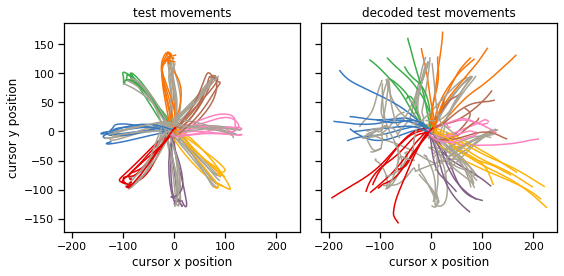

In [17]:
plot_decoder(test_dataset, lds_decoder)

### Problem 2d: [Short answer] Explain your results

The decoded trajectories (i.e. cursor positions) are much smoother than before! Are the decoded velocities (i.e. the mean output by the decoder) similarly smooth?

---

_Your answer here_

## Part 3: Direct decoding with structured prediction

One of the limitations of the LDS in Part 2 is that it treated the spikes as a **linear function** of the instantaneous velocity with **additive Gaussian** noise. We could work on the encoder and instead substitute a Poisson GLM for $p(\mathbf{y}_{i,t} \mid \mathbf{x}_{i,t})$, for example, but that would destroy the conjugacy of the model, and the resulting posterior distribution would no longer have a closed form. 

A common approach to Bayesian inference in "non-conjugate" models is to approximate the resulting posterior with a Gaussian distribution; e.g. via Laplace approximation. Note that the Gaussian approximation to the non-conjugate model's posterior is not the same as the posterior under a linear Gaussian model&mdash;it is influenced by the nonlinear likelihood model, for instance.

That said, if we're ultimately going to approximate the posterior as a Gaussian, why not just _learn_ to output a Gaussian distribution whose mean and covariance are some function of the spikes $\mathbf{y}_i$? There are a few challenges:
- The output of the model would include a $2T \times 2T$ covariance matrix, which grows quadratically with the length of the input.
- In general, our approach should handle arbitrary length time series (even though $T$ is fixed in this dataset). 

To handle these two concerns, we'll develop a _structured_ prediction model that constrains the Gaussian covariance matrix to mimic that of an LDS. In particular, we'll constrain the inverse covariance matrix (aka the precision matrix) to be block-tridiagonal, as in the LDS. However, we'll allow the diagonal blocks of $\mathbf{J}$ and the entries in $\mathbf{h}$ to be learned, nonlinear functions of the spike train.

Concretely, we'll implement the following model:

$$
\begin{aligned}
p(\mathbf{x}_i \mid \mathbf{y}_i) 
&= \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \\
\boldsymbol{\Sigma} &= \mathbf{J}^{-1}\\
\boldsymbol{\mu} &= \mathbf{J}^{-1} \mathbf{h}
\end{aligned}
$$

where $\mathbf{J}$ and $\mathbf{h}$ have blocks,

$$
\begin{aligned}
\mathbf{J}_{t,t-1} &= -\mathbf{Q}^{-1} \mathbf{A} \\
\mathbf{J}_{tt} &= \mathbf{Q}^{-1} + \mathbf{A}^\top \mathbf{Q}^{-1} \mathbf{A} + f(\mathbf{y}_{i,t-\Delta:t+\Delta}) \\
\mathbf{h}_{t} &= g(\mathbf{y}_{i,t-\Delta:t+\Delta})
\end{aligned}
$$

Here, $f$ and $g$ are learned functions of the data in a window of size $2\Delta$ around the current bin. 
(Note that you'll have to handle edge cases in $J_{11}$ and $J_{TT}$ as in Part 2.)

This model retains the LDS prior that couples the velocities via a linear Gaussian model, but it allows richer functions of the data in place of the likelihood. Let's see if we can get this model to improve on the decoders above!


### Problem 3a: Implement a structured decoder with features from a CNN

Implement the functions $f$ and $g$ above by first passing the spikes through a `Conv1d` layer with 96 input channels, `interm_dim` output channels, a kernel of size `kernel_size`, and half that padding on either end to obtain a `T x interm_dim` output. Pass the output through a `relu` and then apply two separate linear layers. 
1. The first linear layer gives you a `Tx2` tensor containing the linear coefficients $\mathbf{h}_t$.
2. The second layer gives you a `Tx2` tensor which you'll then pass through a softplus to make non-negative. Add those non-negative entries to the diagonals of your precision blocks $\mathbf{J}_{tt}$. 

In [18]:
class StructuredDecoder(nn.Module):
    def __init__(self, Q0, A, Q, 
                 num_channels=96,
                 kernel_size=5,
                 interm_dim=10):
        super(StructuredDecoder, self).__init__()
        self.Q0 = Q0
        self.A = A
        self.Q = Q
        
        # Initialize the layer
        self.conv = nn.Conv1d(num_channels, interm_dim, 
                              kernel_size=kernel_size,
                              padding=kernel_size//2)
        
        self.linear_h = nn.Linear(interm_dim, 2)
        self.linear_J = nn.Linear(interm_dim, 2)
        
    def forward(self, spikes):
        """
        spikes: T x 96 array of spikes for a single trial
        returns: (mu, Sigma) where 
            - mu is the (T x 2) posterior mean of the velocity
            - Sigma is the (2T x 2T) posterior covariance matrix
        """
        # Get the model parameters so we don't always have to reference self
        Q0, A, Q = self.Q0, self.A, self.Q
        Y = spikes
        T, _ = Y.shape

        ###
        # YOUR CODE BELOW
        
        # Initialize the diagonal and lower diagonal blocks
        J_diag = torch.zeros(T, 2, 2)
        J_lower_diag = torch.zeros(T-1, 2, 2)

        # Fill them in
        ...
        
        # Construct the full J matrix
        J = symm_block_tridiag(J_diag, J_lower_diag)

        # Construct h
        h = ...

        # Convert to standard parameters
        mu = ...
        Sigma = ...
        ###
        
        # Explicitly symmetrize and add a small bias to ensure PSD
        Sigma = 0.5 * (Sigma + Sigma.T) + 1e-4 * torch.eye(J.shape[0])
        assert torch.all(torch.isfinite(mu))
        assert torch.all(torch.isfinite(Sigma))
        return mu, Sigma
        
torch.manual_seed(0)
struct_decoder = StructuredDecoder(Q0_hat, A_hat, Q_hat)


# Check the decoder on an example trial
with torch.no_grad():
    mu, Sigma = struct_decoder(train_dataset[0].spikes)
    assert torch.isclose(torch.linalg.norm(mu), torch.tensor(1.1452), atol=1e-4)
    assert torch.isclose(torch.linalg.norm(Sigma), torch.tensor(4.9322), atol=1e-4)


### Train the model

Training structured decoder model. This should take about 4 minutes...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

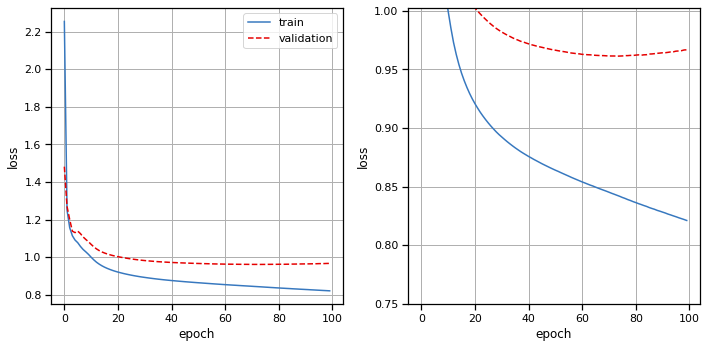

In [19]:
print("Training structured decoder model. This should take about 4 minutes...")

# del train_data["orig_spikes"]
train_losses, val_losses = train_model(struct_decoder, 
                                       train_dataset,
                                       val_dataset,
                                       mvn_loss, 
                                       lr=1e-4, 
                                       lr_step_size=100)

# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("loss")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("loss")
axs[1].set_ylim(top=val_losses[20])
axs[1].grid(True)

plt.tight_layout()

### Plot the decoded movements 

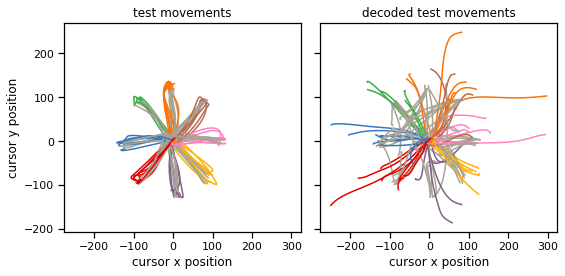

In [20]:
with torch.no_grad():
    plot_decoder(test_dataset, struct_decoder)

### Compute and report the test loss for all three decoders

Compute the test loss for all three models, averaging the loss over test trial. Compare to a baseline of indepedent Gaussian velocities for each trial and timesteps. 

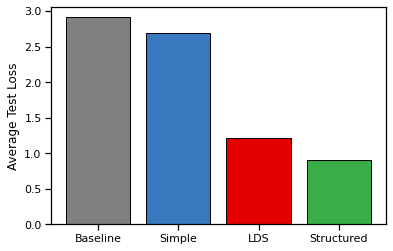

In [21]:
def make_baseline(dataset):
    """
    Baseline: independent normal velocities for each trial and timestep.
    """
    _, T, _ = dataset.velocity.shape
    mu_base = torch.mean(dataset.velocity.reshape(-1, 2), axis=0)
    mu_base = mu_base * torch.ones((T, 2))
    Sigma_base = torch.cov(dataset.velocity.reshape(-1, 2).T) 
    Sigma_base = torch.block_diag(*(Sigma_base * torch.ones(T, 2, 2)))
    return lambda y: (mu_base, Sigma_base)


def compute_test_loss(decoder):
    loss = 0 
    for trial in test_dataset:
        loss += mvn_loss(decoder(trial.spikes), trial.velocity)
    return loss / len(test_dataset)
    

# Make a bar plot
with torch.no_grad():
    baseline = make_baseline(train_dataset)
    plt.bar(0, compute_test_loss(baseline), color='gray', ec='k')
    plt.bar(1, compute_test_loss(simple_decoder), color=palette[0], ec='k')
    plt.bar(2, compute_test_loss(lds_decoder), color=palette[1], ec='k')
    plt.bar(3, compute_test_loss(struct_decoder), color=palette[2], ec='k')
    plt.xticks([0, 1, 2, 3], ["Baseline", "Simple", "LDS", "Structured"])
    plt.ylabel("Average Test Loss")

## Part 4: Discussion



### Problem 4a
Why do you think we decoded velocity instead of position? What are the limitations of decoding velocity and then integrating it to obtain position estimates?

---

_Your answer here_

### Problem 4b

Decoding performance could be limited by either the raw amount of information about movement contained in the neural activity, or by the particular form of decoder that we employed. What do you think the limiting factor is in this lab?
 Why?

---

_Your answer here_

### Problem 4c

We only used the mean velocity output by the decoder, $\boldsymbol{\mu}$. How could you use the covariance $\boldsymbol{\Sigma}$?

---

_Your answer here_

### Problem 4d
Suppose we wanted to use the decoder to control a prosthetic limb and we needed it to work for months or years at a time. Would you expect the same decoder parameters to work throughout that time course, and if not, how might you adapt the decoder over time to maintain or potentially even improve performance?

---

_Your answer here_

## Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF. 

**Option 1 (best case): ipynb &rarr; pdf** Run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf lab5_teamname.ipynb
```

Unfortunately, `nbconvert` sometimes crashes with long notebooks. If that happens, here are a few options:


**Option 2 (next best): ipynb &rarr; tex &rarr; pdf**:
```
jupyter nbconvert --to latex lab5_teamname.ipynb
pdflatex lab5_teamname.tex
```

**Option 3: ipynb &rarr; html &rarr; pdf**:
```
jupyter nbconvert --to html lab5_teamname.ipynb
# open lab5_teamname.html in browser and print to pdf
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```
- `pdflatex`: It comes with standard TeX distributions like TeXLive, MacTex, etc. Alternatively, you can upload the .tex and supporting files to Overleaf (free with Stanford address) and use it to compile to pdf.

**Upload** your .ipynb and .pdf files to Gradescope. 

**Only one submission per team!**